# Importing Libraries


In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Challenge1

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1hzamFV4kC27mUMEV9YGWnQmv2-k5TZvo/Challenge1


In [2]:
## Libraries we eork with during the game

import tensorflow as tf
import scipy
import Cython
import numpy as np
import matplotlib
import seaborn as sns
import pandas as pd
import imutils
import tqdm
import shutil
import psutil
import h5py

# Fix randomness and hide warnings
seed = 42
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageEnhance, ImageFilter
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)


from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import Model
import scipy as sp
from tqdm import tqdm

2.14.0


In [3]:
pip install keras_cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 32.7 MB/s eta 0:00:00


In [4]:
import keras_cv

Using TensorFlow backend


# Removing the suprises


In [5]:
Base = tfk.models.load_model('Base')
embedding = tfk.Sequential(Base.layers[:-1])  #this way it only takes the features and not the output
embedding.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv0 (Conv2D)              (None, 96, 96, 32)        896       
                                                                 
 relu0 (ReLU)                (None, 96, 96, 32)        0         
                                                                 
 mp0 (MaxPooling2D)          (None, 48, 48, 32)        0         
                                                                 
 conv1 (Conv2D)              (None, 48, 48, 64)        18496     
                                                                 
 relu1 (ReLU)                (None, 48, 48, 64)        0         
                                                                 
 mp1 (MaxPooling2D)          (None, 24, 24, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 24, 24, 128)       7

In [6]:
## Loading the data

TEST = np.load('public_data.npz', allow_pickle=True)
X_data=TEST['data']
y_data=TEST['labels']
X=X_data/255
Y=(y_data=='unhealthy').astype(int)    #this creates a vector of 0 and 1

labels = {0:'healthy', 1:'unhealthy'}
#Run this only once because it takes time (computational cost)
features = embedding.predict(X,batch_size=32,verbose=0)

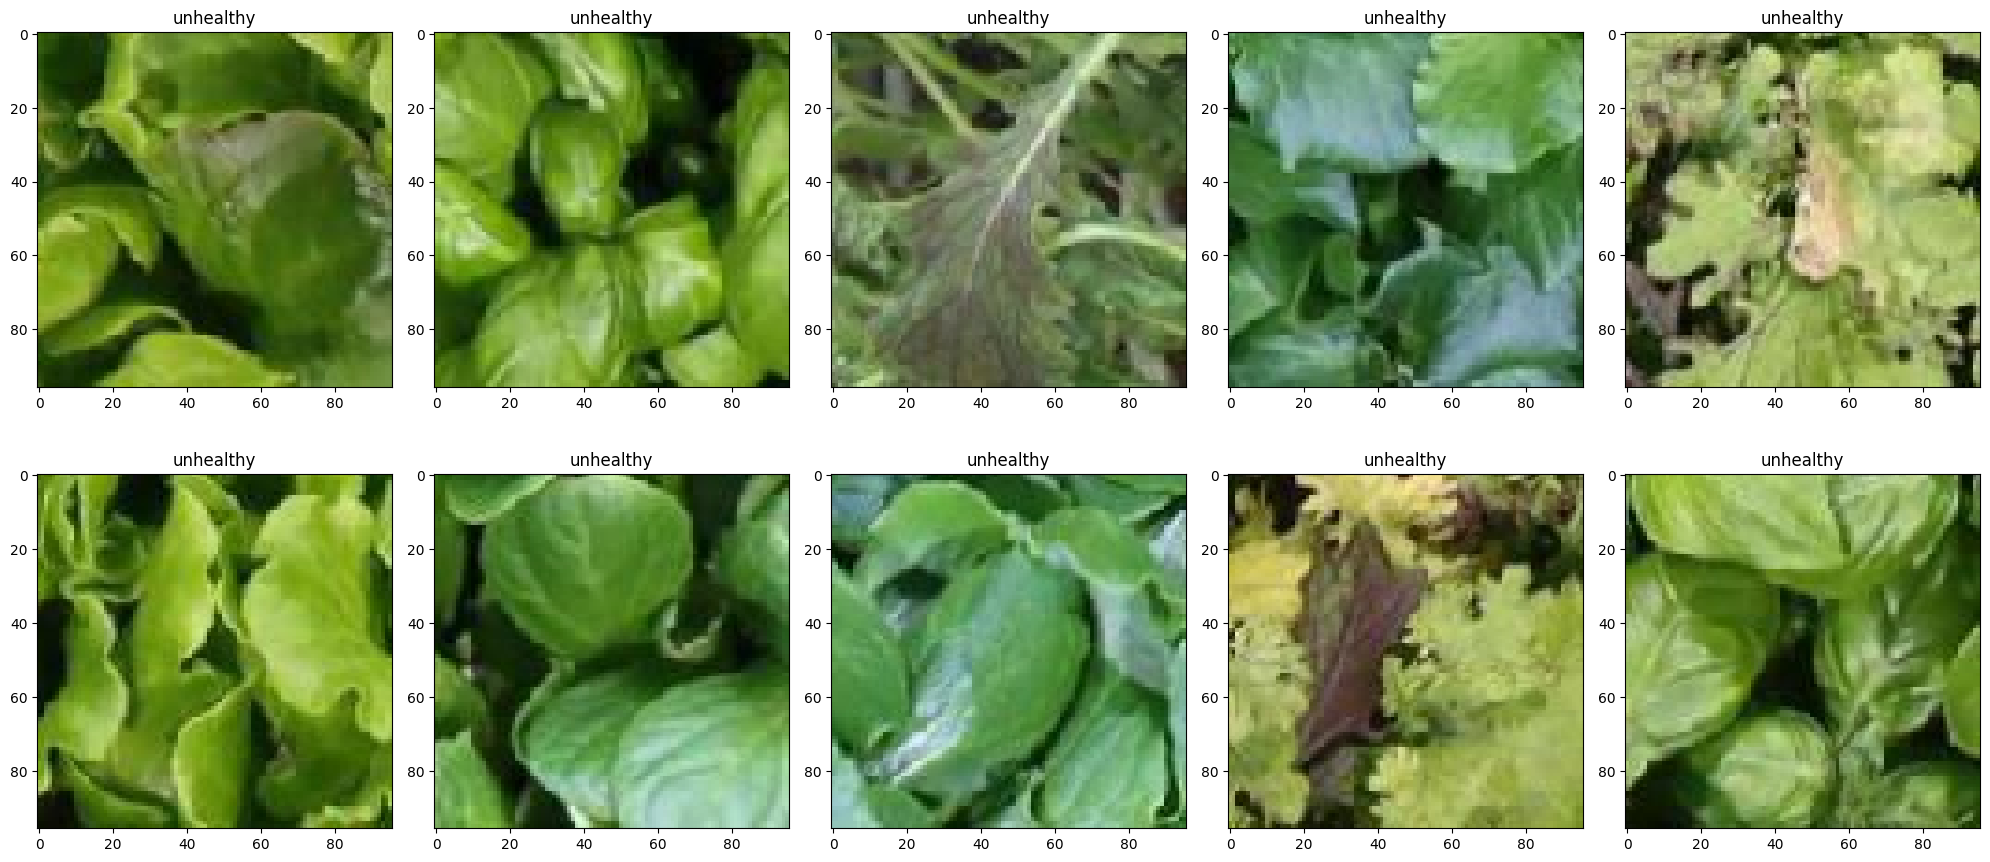

In [7]:
#showing the first 10 unhealthy plants

num_img = 10
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
i=0
t=0
# Iterate through the selected number of images
while i<num_img:
    if y_data[t]=='unhealthy':
      ax = axes[i%2, i%num_img//2]
      ax.imshow(X[t])
      ax.set_title(f'{labels[Y[t]]}')
      i=i+1
    t=t+1


# Adjust layout and display the images
plt.tight_layout()
plt.show()

healthy


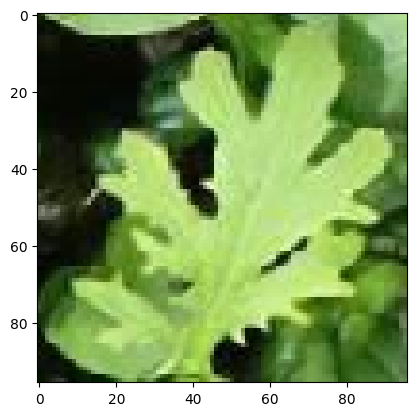

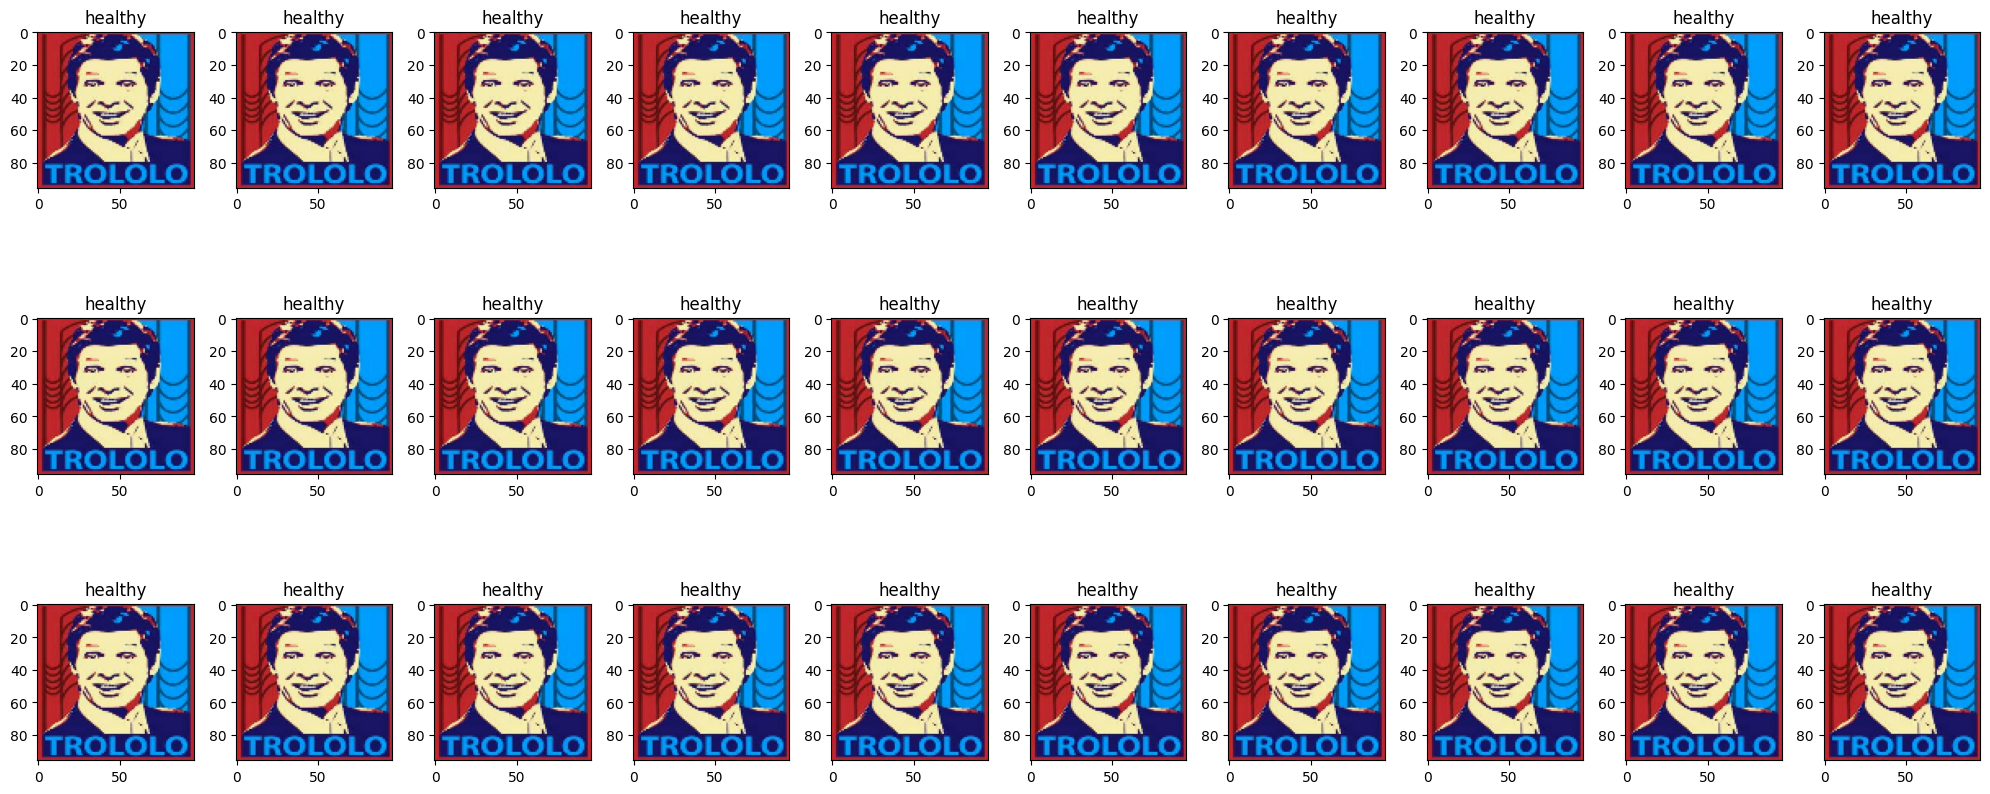

In [9]:
# Checking the images which are most distant from a plant

index = 0

#dataset_features = embedding.predict(X,batch_size=32,verbose=0)
image = np.expand_dims(X[index],axis=0)
image_features = embedding.predict(image,verbose=0)  #extracting the vector
print(labels[Y[index]])
plt.imshow(X[index])
plt.show()


distances = -np.mean(np.square(features - image_features),axis=-1)   #calculating distances from a random plant
ordered_images = X[distances.argsort()]  #ordering for the distance

# Inspect the data
num_img = 30
num_ax = num_img//10
fig, axes = plt.subplots(num_ax, num_img//num_ax, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i%num_ax, i%num_img//num_ax]
    ax.imshow(ordered_images[i])
    ax.set_title(labels[Y[distances.argsort()[i]]])

plt.tight_layout()
plt.show()

[4927 2889 3896 4049  989 1988 1064 1981  783 5165 3899 4735 3904  701
 3376  529 1630 4719 1149 4411 1690 1697  486 2929 2564 4883 4055  725
 2191 2192 3436 4903 4897 1101 1384 2831 4310 2198 2596 2593 2839 4314
 2581 4907  753 3451 1541 2796 4316 3821  723 1172 1939 3835 1757 5080
 3086 4618 2496  412 4605 1828 4848 1759 3964 4557 3740 2676 3950 3108
 3989 1609 4766 1191 5048  338 1190 2348 1065 3490 4837 4503  971 5143
 2150 1752 2487 3800 3049 1903 1044 4860  961 2426  898  434 3700 4100
 4368 2090  658 3488 2800 3885 2734 2736 2081  622 4097  171 2755 2727
 3862 2779 2830 3286 2380 3055 5082 1866 1268 1265 3946 3105 3988 4476
 4694 3144 4475 3155 1280  599 4507 3931 1333 5121 2022 1651 4740 2864
  207 3410  571 2866 1977 2937  506 3927 1938 3033 2913 1806 4144 3806
 3572 3583 4779 1028 1554 1466  974 4150 5171   58 2515   95 3770 3666
  901 1594 3811 4282 2435 1443 1528 2328 3802 3801  779 1483  692 2451
  840 2453 4857 2675 2261 2311  137  138 4118 2665 2663  827 3688  880]

unhe

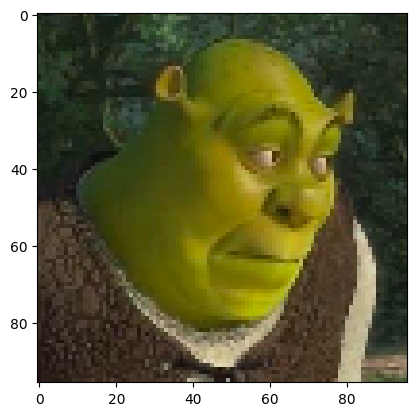

unhealthy


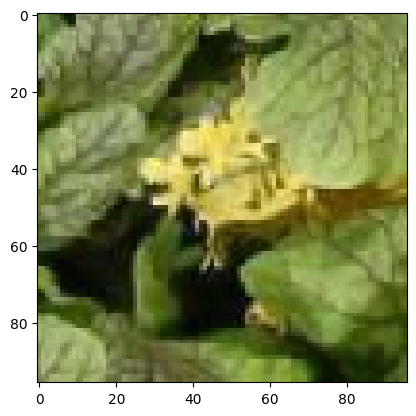

In [10]:
# Removing Shrek and Trololo

index=distances.argsort()[:196]
print(index)
print()
index1=distances.argsort()[196]

image = np.expand_dims(X[index[-1]],axis=0)
image_features = embedding.predict(image,verbose=0)
print(labels[Y[index[-1]]])
plt.imshow(X[index[-1]])
plt.show()

image = np.expand_dims(X[index1],axis=0)
image_features = embedding.predict(image,verbose=0)
print(labels[Y[index1]])
plt.imshow(X[index1])
plt.show()

In [11]:
print(index.size)

X_new = np.delete(X_data, index, axis=0)
y_new = np.delete(y_data, index, axis=0)

print('\n',X_data.shape, '   ', X_new.shape)
print('\n',y_data.shape, '   ', y_new.shape)

X_new2=X_new/255
New_features = embedding.predict(X_new2,batch_size=32,verbose=0)

196

 (5200, 96, 96, 3)     (5004, 96, 96, 3)

 (5200,)     (5004,)


healthy


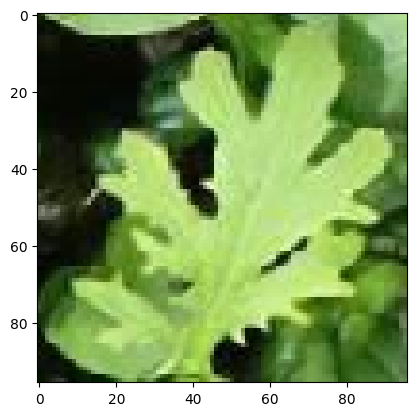

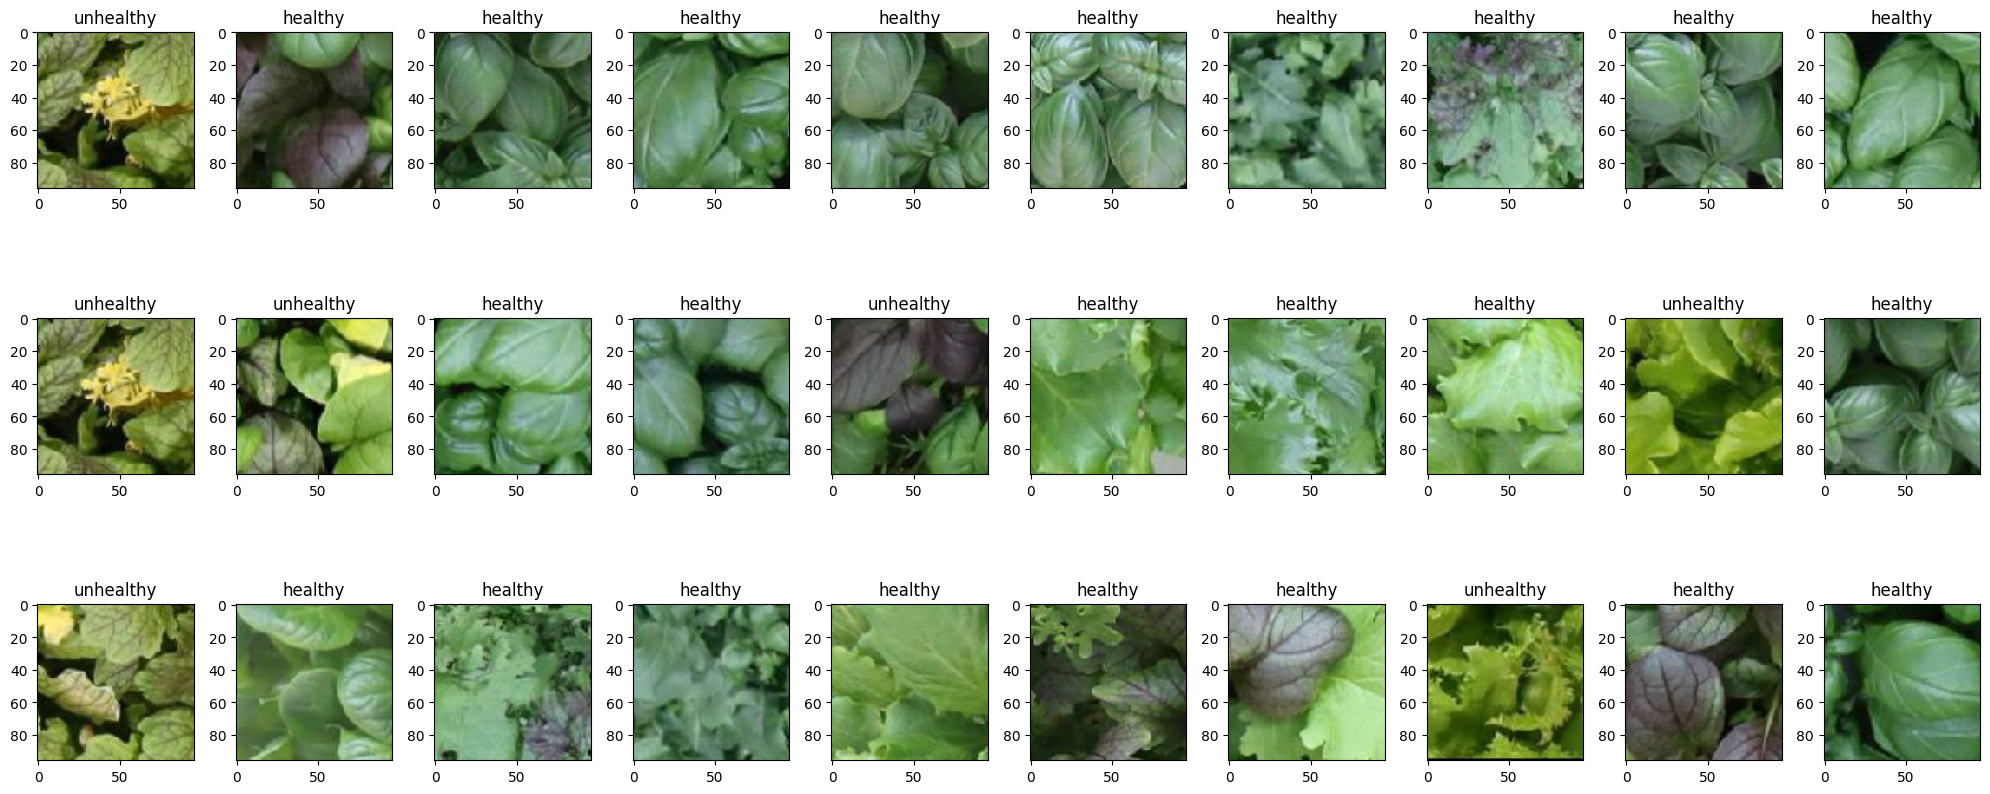

In [12]:
## Checking again the data

ind = 0

image = np.expand_dims(X_new2[ind],axis=0)
image_feat = embedding.predict(image,verbose=0)
print(y_new[ind])
plt.imshow(X_new2[ind])
plt.show()


dist = -np.mean(np.square(New_features - image_feat),axis=-1)
ordered = X_new2[dist.argsort()]

# Inspect the data
num_img = 30
num_ax = num_img//10
fig, axes = plt.subplots(num_ax, num_img//num_ax, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i%num_ax, i%num_img//num_ax]
    ax.imshow(ordered[i])
    ax.set_title(y_new[dist.argsort()[i]])

plt.tight_layout()
plt.show()

# Removing doubles

healthy


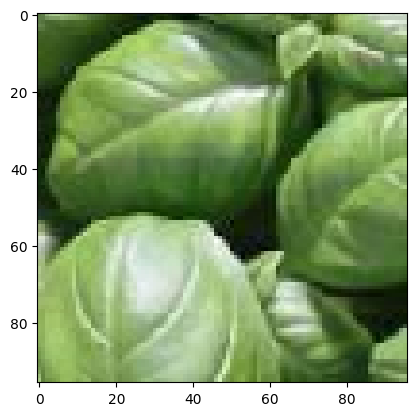

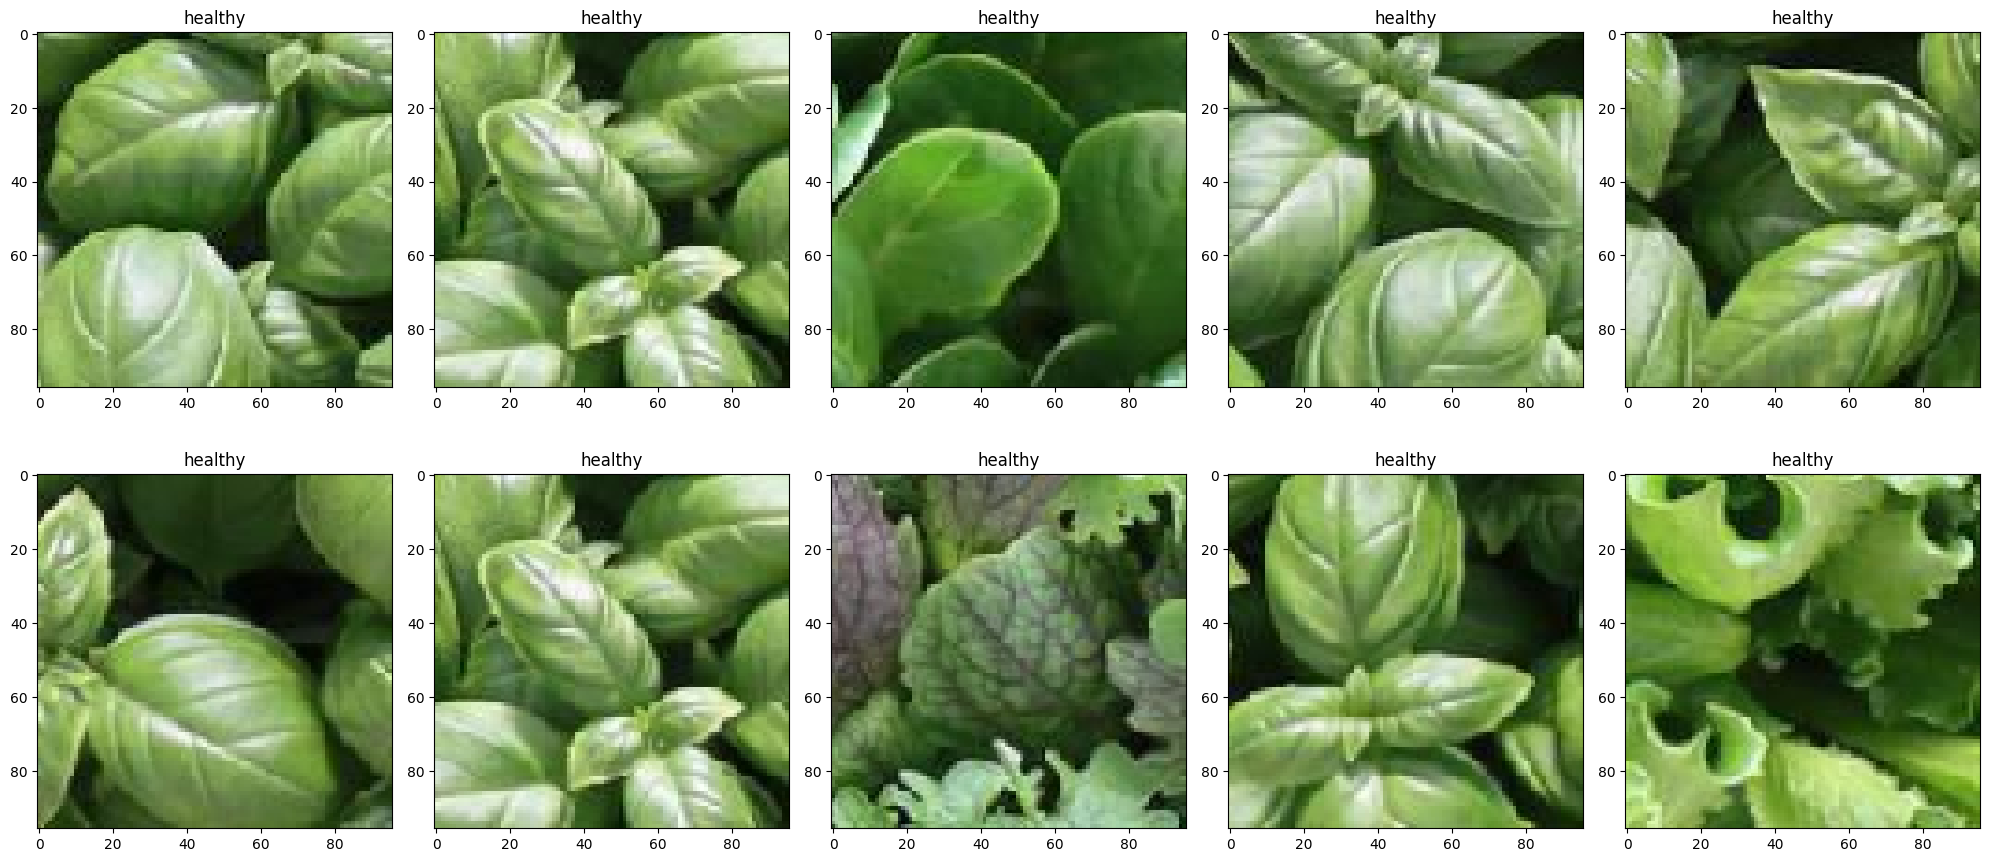

In [13]:
# We do as before, but now we search the nearest images

ind = 5

image = np.expand_dims(X_new2[ind],axis=0)
image_feat = embedding.predict(image,verbose=0)
print(y_new[ind])
plt.imshow(X_new2[ind])
plt.show()


dist = np.mean(np.square(New_features - image_feat),axis=-1)
ordered = X_new2[dist.argsort()]

# Inspect the data
num_img = 10
num_ax = num_img//5
fig, axes = plt.subplots(num_ax, num_img//num_ax, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i%num_ax, i%num_img//num_ax]
    ax.imshow(ordered[i])
    ax.set_title(y_new[dist.argsort()[i]])

plt.tight_layout()
plt.show()

In [16]:
count=0
coppie = []

for j in range(y_new.size):

  Dist = np.mean(np.square(New_features - New_features[j]),axis=-1)
  k=0

  while Dist[Dist.argsort()][k]  ==0 :     # if the distance is 0 then it's the same image
    if j != Dist.argsort()[k] :
      coppie.append([j,Dist.argsort()[k]])
      print(coppie[count])
      count=count+1
    k=k+1
print(count)
coppie=np.array(coppie)

coppieDoppie = coppie
print(coppie.shape)

[1, 512]
[3, 3993]
[23, 3123]
[23, 155]
[44, 1207]
[47, 2486]
[54, 3267]
[59, 2225]
[87, 295]
[139, 4816]
[144, 453]
[144, 328]
[146, 237]
[154, 704]
[155, 23]
[155, 3123]
[185, 1295]
[186, 526]
[191, 4769]
[191, 3784]
[221, 2788]
[237, 146]
[270, 3884]
[278, 1891]
[279, 565]
[295, 87]
[328, 453]
[328, 144]
[329, 785]
[354, 4703]
[373, 2118]
[386, 2206]
[388, 1722]
[388, 1806]
[388, 4746]
[396, 3664]
[427, 4790]
[433, 981]
[446, 1742]
[453, 144]
[453, 328]
[455, 3874]
[491, 1820]
[496, 2802]
[501, 3934]
[502, 3480]
[502, 3262]
[512, 1]
[526, 186]
[540, 957]
[549, 2635]
[565, 279]
[576, 1105]
[622, 2331]
[625, 859]
[626, 3740]
[658, 4714]
[663, 2186]
[701, 4017]
[704, 154]
[708, 2605]
[723, 1853]
[743, 1654]
[745, 3279]
[764, 1422]
[785, 329]
[788, 2120]
[800, 2944]
[824, 2976]
[824, 4360]
[859, 625]
[885, 1995]
[920, 1700]
[948, 2439]
[948, 4945]
[957, 540]
[969, 3848]
[981, 433]
[1028, 2769]
[1045, 4599]
[1056, 2689]
[1061, 1657]
[1081, 1900]
[1095, 4408]
[1105, 576]
[1118, 2213]
[112

In [ ]:
jj=0
while jj < coppie.shape[0]:
  x = np.array([coppie[jj][1],coppie[jj][0]])
  mask = np.any(coppie!=x, axis=1)
  mask[jj]=True
  coppie = coppie[mask]
  jj=jj+1
print(coppie.shape)
print(coppie)

print(coppie[:,1])
unique = np.unique(coppie[:,1])

In [ ]:
print(unique.size)

X_NoDoub = np.delete(X_new, unique, axis=0)
y_NoDoub = np.delete(y_new, unique, axis=0)

print('\n',X_new.shape, '   ', X_NoDoub.shape)
print('\n',y_new.shape, '   ', y_NoDoub.shape)

In [ ]:
X_ND=X_NoDoub/255
NoDoub = embedding.predict(X_ND,batch_size=32,verbose=0)

count=0

for j in range(y_NoDoub.size):

  Dist = np.mean(np.square(NoDoub - NoDoub[j]),axis=-1)
  k=0

  while Dist[Dist.argsort()][k]  ==0 :
    if j != Dist.argsort()[k] :
      count=count+1
    k=k+1
print(count)

In [ ]:
# Calling again as X and Y

X = X_NoDoub
Y = y_Nodoub

# Processing and building a first model


In [ ]:
# Splitting in Train and Validation

Y = tfk.utils.to_categorical(Y)

X_train, X_val, y_train, y_val = train_test_split(
    X,
    Y,
    test_size = 0.2,
    random_state = seed,
    stratify = Y
)
# Print the shapes of the loaded datasets
print("Training-Validation Data Shape:", X.shape)
print("Training-Validation Label Shape:", Y.shape)
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

In [ ]:
unique, count = np.unique(y_train_val[:,1], return_counts=True)
print(count)
unique, count = np.unique(y_test, return_counts=True)
print(count)
unique, count = np.unique(y_train[:,1], return_counts=True)
print(count)
unique, count = np.unique(y_val[:,1], return_counts=True)
print(count)

In [ ]:
# Define key model parameters
input_shape = X_train.shape[1:]  # Input shape for the model / bi dimensional
output_shape = y_train.shape[1]  # Output shape for the model / is one dimensional
batch_size = 64               # Batch size for training
epochs = 300                  # Number of training epochs

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

In [ ]:
# Building the base model

def build_model(input_shape=input_shape, output_shape=output_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv0')(input_layer)
    x = tfkl.ReLU(name='relu0')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)

    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv1')(x)
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.ReLU(name='relu2')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)

    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.ReLU(name='relu3')(x)
    x = tfkl.MaxPooling2D(name='mp3')(x)

    x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', name='conv4')(x)
    x = tfkl.ReLU(name='relu4')(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    x=tfkl.Dense(units=128, activation='softmax',name='Output1')(x)
    output_layer = tfkl.Dense(units=2, activation='softmax',name='Output2')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    # Return the model
    return model

In [ ]:
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, mode='auto'),
]

model = build_model()
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Compute classification metrics
train_pred=np.argmax(Modello.predict(X_train, verbose=0), axis=-1)
train_accuracy = accuracy_score(y_train[:,1], train_pred)
val_pred=np.argmax(Modello.predict(X_val, verbose=0), axis=-1)
val_accuracy = accuracy_score(y_val[:,1], val_pred)
test_accuracy = accuracy_score(y_test, predicted)
precision = precision_score(y_test, predicted, average='macro')
recall = recall_score(y_test, predicted, average='macro')
f1 = f1_score(y_test, predicted, average='macro')

# Display the computed metrics
print('Training Accuracy:', train_accuracy.round(4))
print('Validation Accuracy:', val_accuracy.round(4))
print('Test Accuracy:', test_accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

From here up to the decision to persue Transfer Learning we went through a long process of hyperparameters and augmentation parameter tuning through the use of of our newly implemented code that could be found in the attached notebook called "TestA". During this period of time we also began implementing a new deeper architecure from scratch called "manyConv" which led to positive result in trainig and validation but performed poorly on the test despite multiple testig and so it was discarded as a vailable option.

# manyConv

In [ ]:
def build_model(input_shape=input_shape, output_shape=output_shape, dropout_rate=1/6):
    tf.random.set_seed(seed)

    preprocessing = tf.keras.Sequential([
        #tfkl.RandomBrightness(0.5, value_range=(0,1)),
        tfkl.RandomContrast(0.8),
        tfkl.RandomTranslation(0.2,0.2),
        tfkl.RandomFlip("horizontal"),
        tfkl.RandomRotation(0.2),
        tfkl.RandomZoom(0.2),

    ], name='preprocessing')

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    preprocessing = preprocessing(input_layer)

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv0')(preprocessing)
    x = tfkl.ReLU(name='relu0')(x)
    x = tf.keras.layers.BatchNormalization(name='batch_norm0')(x)
    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv01')(x)
    x = tfkl.ReLU(name='relu01')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)
    x = tfkl.Dropout(dropout_rate, seed=seed)(x)

    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv1')(x)
    x = tfkl.ReLU(name='relu1')(x)
    x = tf.keras.layers.BatchNormalization(name='batch_norm1')(x)
    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv11')(x)
    x = tfkl.ReLU(name='relu11')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)
    x = tfkl.Dropout(dropout_rate, seed=seed)(x)

    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.ReLU(name='relu2')(x)
    x = tf.keras.layers.BatchNormalization(name='batch_norm2')(x)
    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv21')(x)
    x = tfkl.ReLU(name='relu21')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)
    x = tfkl.Dropout(dropout_rate, seed=seed)(x)

    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.ReLU(name='relu3')(x)
    x = tf.keras.layers.BatchNormalization(name='batch_norm31')(x)
    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv31')(x)
    x = tfkl.ReLU(name='relu31')(x)
    x = tf.keras.layers.BatchNormalization(name='batch_norm32')(x)
    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv32')(x)
    x = tfkl.ReLU(name='relu32')(x)
    x = tfkl.MaxPooling2D(name='mp3')(x)
    x = tfkl.Dropout(dropout_rate, seed=seed)(x)

    x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', name='conv4')(x)
    x = tfkl.ReLU(name='relu4')(x)
    x = tf.keras.layers.BatchNormalization(name='batch_norm41')(x)
    x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', name='conv41')(x)
    x = tfkl.ReLU(name='relu41')(x)
    x = tf.keras.layers.BatchNormalization(name='batch_norm42')(x)
    x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', name='conv42')(x)
    x = tfkl.ReLU(name='relu42')(x)
    x = tfkl.Dropout(dropout_rate, seed=seed)(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)


    x = tfkl.Dense(units=128, activation='relu',name='Dense0')(x)
    output_layer = tfkl.Dense(units=2, activation='softmax',name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    # Return the model
    return model

# Tranfer Learning andrea

In [ ]:
batch_size=64

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.4,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='wrap',
    brightness_range=[0.7, 1.3],
)

# Create a generator that applies data augmentation to your images
augmented_generator = datagen.flow(X_train, y_train, batch_size=batch_size, seed=69)

In [ ]:
base_model=tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3),
    pooling='avg',
    include_preprocessing=True,
)
base_model.trainable = False

In [ ]:
dropout_rate=1/6
he_initializer = tf.keras.initializers.HeNormal()

inputs = tfk.Input(shape=(96, 96, 3))

x = base_model(inputs)
x=tfkl.Dense(128, activation = 'relu', kernel_initializer=he_initializer,kernel_regularizer=tf.keras.regularizers.l2(2e-5), name='Dense1')(x)
x = tfkl.Dropout(dropout_rate, seed=seed)(x)
x=tfkl.Dense(64, activation = 'relu', kernel_initializer=he_initializer,kernel_regularizer=tf.keras.regularizers.l2(2e-5), name='Dense2')(x)
x = tfkl.Dropout(dropout_rate, seed=seed)(x)

outputs = tfkl.Dense(2, activation='softmax', name='Outputs')(x)

tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='tl_model')

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Convert y_train to a 1-dimensional array
y_train_flat = np.argmax(y_train, axis=1)

# Assuming you have the number of classes
num_classes = len(set(y_train_flat))


# Compute class weights for the weighted cross-entropy loss
# class_weights = compute_class_weight('balanced', classes=range(num_classes), y=y_train_flat)
# class_weights_dict = {i: class_weights[i] for i in range(num_classes)}

# Manually set class weights to simulate a 35/65 distribution in favor of the unhealthy class
class_weights_dict = {0: 0.35, 1: 0.65}  # Adjust the values based on your desired distribution

# Convert the class weights to a TensorFlow-compatible format
class_weights_tensor = tf.constant(list(class_weights_dict.values()), dtype=tf.float32)

# Define the weighted cross-entropy loss function
def weighted_categorical_crossentropy(class_weights):
    def loss(y_true, y_pred):
        # Clip predictions to avoid log(0) and log(1) issues
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        # Compute the weighted cross-entropy loss
        weighted_losses = -tf.reduce_sum(class_weights * y_true * tf.math.log(y_pred), axis=-1)
        return tf.reduce_mean(weighted_losses)
    return loss

In [ ]:
tl_model.compile(loss=weighted_categorical_crossentropy(class_weights_tensor), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])
tl_model.summary()

In [ ]:
# Train the model
history = tl_model.fit(
    augmented_generator,
    batch_size = batch_size,
    epochs = 300,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True)]
).history

In [ ]:
# Compute classification metrics
train_pred=np.argmax(tl_model.predict(X_train, verbose=0), axis=-1)
train_accuracy = accuracy_score(y_train[:,1], train_pred)
val_pred=np.argmax(tl_model.predict(X_val, verbose=0), axis=-1)
val_accuracy = accuracy_score(y_val[:,1], val_pred)

# Display the computed metrics
print('Training Accuracy:', train_accuracy.round(4))
print('Validation Accuracy:', val_accuracy.round(4))

# Test Time augmentation

In [ ]:
#We define 3 different test time augmentation and test the on the full dataset

In [ ]:
#model.py con test completo

import os
import tensorflow as tf
from tensorflow.keras import layers as tfkl
import numpy as np

class model:
  def __init__(self, path):
    self.model = tf.keras.models.load_model(os.path.join(path, 'SubmissionModel'))

  def trasl(self, image, a):
    x1 = tfkl.RandomTranslation((a,a),(0,0), fill_mode='wrap')(image)
    x2 = tfkl.RandomTranslation((0,0),(a,a), fill_mode='wrap')(image)
    x3 = tfkl.RandomTranslation((-a,-a),(0,0), fill_mode='wrap')(image)
    x4 = tfkl.RandomTranslation((0,0),(-a,-a), fill_mode='wrap')(image)
    o1 = self.model.predict(x1)
    o2 = self.model.predict(x2)
    o3 = self.model.predict(x3)
    o4 = self.model.predict(x4)
    return np.mean(np.stack((o1, o2, o3, o4)), axis=0)

  def rotation(self, image, a):
    x1 = tfkl.RandomRotation((a, a),fill_mode='reflect')(image)
    x2 = tfkl.RandomRotation((0.25+a,0.25+a),fill_mode='reflect')(image)
    x3 = tfkl.RandomRotation((0.5+a, 0.5+a),fill_mode='reflect')(image)
    x4 = tfkl.RandomRotation((0.75+a,0.75+a),fill_mode='reflect')(image)
    o1 = self.model.predict(x1)
    o2 = self.model.predict(x2)
    o3 = self.model.predict(x3)
    o4 = self.model.predict(x4)
    return np.mean(np.stack((o1,o2,o3,o4)), axis=0)


  def zoom(self, image, zoom_range):
    return tfkl.RandomZoom(zoom_range)(image)

  def bright(self, image, a):
    return tfkl.RandomBrightness(a, value_range=(0,255))(image)

  def contrast(self, image, a):
    return tfkl.RandomContrast(a)(image)



  def predict(self, X):
    f1 = self.model.predict(np.flip(X, axis=1))
    f2 = self.model.predict(np.flip(X, axis=2))
    r4 = self.rotation(X,0)
    out1 = (f1+f2+4*r4)/6
    t= self.trasl(X,0.3)
    r = self.rotation(X, 0.12)
    z = self.model.predict(self.zoom(X,0.4))
    b = self.model.predict(self.bright(X,0.2))
    c = self.model.predict(self.contrast(X,0.5))
    out2 = 0.75*out1+0.08*t+0.05*z+0.04*r+0.04*b+0.04*c
    return tf.argmax(out2, axis=-1)

In [ ]:
#model.py semplice (no zoom, trasl, rot_pic, contr, bright)

import os
import tensorflow as tf
from tensorflow.keras import layers as tfkl
import numpy as np

class model1:
  def __init__(self, path):
    self.model = tf.keras.models.load_model(os.path.join(path, 'SubmissionModel'))

  def rotation(self, image, a):
    x1 = tfkl.RandomRotation((a, a))(image)
    x2 = tfkl.RandomRotation((0.25+a,0.25+a))(image)
    x3 = tfkl.RandomRotation((0.5+a, 0.5+a))(image)
    x4 = tfkl.RandomRotation((0.75+a,0.75+a))(image)
    o1 = self.model.predict(x1)
    o2 = self.model.predict(x2)
    o3 = self.model.predict(x3)
    o4 = self.model.predict(x4)
    return np.mean(np.stack((o1,o2,o3,o4)), axis=0)

  def predict(self, X):
    f1 = self.model.predict(np.flip(X, axis=1))
    f2 = self.model.predict(np.flip(X, axis=2))
    r4 = self.rotation(X,0)
    out1 = (f1+f2+4*r4)/6
    return tf.argmax(out1, axis=-1)

In [ ]:
#model.py semplice senza 180°

import os
import tensorflow as tf
from tensorflow.keras import layers as tfkl
import numpy as np

class model2:
  def __init__(self, path):
    self.model = tf.keras.models.load_model(os.path.join(path, 'SubmissionModel'))

  def rotation(self, image, a):
    x1 = tfkl.RandomRotation((a, a))(image)
    x2 = tfkl.RandomRotation((0.25+a,0.25+a))(image)
    x4 = tfkl.RandomRotation((0.75+a,0.75+a))(image)
    o1 = self.model.predict(x1)
    o2 = self.model.predict(x2)
    o4 = self.model.predict(x4)
    return np.mean(np.stack((o1,o2,o4)), axis=0)

  def predict(self, X):
    f1 = self.model.predict(np.flip(X, axis=1))
    f2 = self.model.predict(np.flip(X, axis=2))
    r4 = self.rotation(X,0)
    out1 = (f1+f2+3*r4)/5
    return tf.argmax(out1, axis=-1)

In [ ]:
mod = model('')
mod1 = model1('')
mod2 = model2('')

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
DATA = np.load('BalancedData.npz', allow_pickle=True)
X=DATA['data']
y_data=DATA['labels']
Y=(y_data=='unhealthy').astype(float)

# facendo labels[Y] si ottiene il valore in stringa
labels = {0:'healthy', 1:'unhealthy'}
del DATA

In [ ]:
from sklearn.metrics import accuracy_score

acc00 = accuracy_score(Y, np.argmax(mod.model.predict(X), axis=-1))
acc10 = accuracy_score(Y, mod.predict(X))
print(acc00,acc10)

acc01 = accuracy_score(Y, np.argmax(mod1.model.predict(X), axis=-1))
acc11 = accuracy_score(Y, mod1.predict(X))
print(acc01,acc11)

acc02 = accuracy_score(Y, np.argmax(mod2.model.predict(X), axis=-1))
acc12 = accuracy_score(Y, mod2.predict(X))
print(acc02,acc12)


114/114 [==============================] - 4s 39ms/step
0.9075144508670521 0.9229287090558767
114/114 [==============================] - 4s 31ms/step
0.9075144508670521 0.9210019267822736


'\nacc02 = accuracy_score(Y, np.argmax(mod2.model.predict(X), axis=-1))\nacc12 = accuracy_score(Y, mod2.predict(X))\nprint(acc02,acc12)\n'